In [10]:
from typing import Literal
import yfinance as yf
import pandas as pd
import numpy as np
from pypfopt import EfficientFrontier, HRPOpt
from scipy.optimize import minimize

In [11]:
end_date = (pd.Timestamp.now()).strftime("%Y-%m-%d")
start_date = (pd.Timestamp.now() - pd.offsets.DateOffset(years=20)).strftime("%Y-%m-%d")

risk_free_rate = (
    yf.download("^TNX", start=start_date, end=end_date, auto_adjust=True)[
        "Close"
    ].mean()
    / 100
).iloc[0]
price_df = yf.download(
    ["SPY", "TLT", "GLD"], start=start_date, end=end_date, auto_adjust=True
)["Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  3 of 3 completed


In [12]:
def get_cum_ret(df: pd.DataFrame) -> pd.DataFrame:
    res = (1 + df).cumprod()

    return res


def risk_parity_strategy(price_df: pd.DataFrame):
    def risk_parity_objective(weights: pd.DataFrame, cov_matrix: pd.DataFrame):
        variance = weights @ cov_matrix @ weights.T
        marginal_contribution = cov_matrix @ weights
        risk_contribution = np.multiply(weights, marginal_contribution) / variance
        target_risk = np.mean(risk_contribution)
        return np.sum((risk_contribution - target_risk) ** 2)

    cov_matrix = price_df.pct_change().dropna().cov()
    weights = np.ones(len(cov_matrix)) / len(cov_matrix)

    return minimize(
        risk_parity_objective,
        weights,
        args=(cov_matrix,),
        method="SLSQP",
        bounds=[(0, 1)] * len(cov_matrix),
        constraints={"type": "eq", "fun": lambda x: np.sum(x) - 1},
    ).x


def hierarchical_risk_parity_strategy(price_df: pd.DataFrame):
    daily_returns = price_df.pct_change().dropna()
    cov_matrix = price_df.pct_change().dropna().cov()
    opt = HRPOpt(daily_returns, cov_matrix)
    opt.optimize()
    optimised_weights = opt.clean_weights()
    optimised_weights_df = pd.DataFrame.from_dict(
        optimised_weights, orient="index", columns=["weight"]
    )
    return optimised_weights_df


def efficient_frontier_strategy(
    price_df: pd.DataFrame, type_: Literal["max_sharpe", "min_volatility"]
):
    mean_hist_ret = price_df.pct_change().dropna().mean() * 252
    cov_matrix = price_df.pct_change().dropna().cov()
    opt = EfficientFrontier(mean_hist_ret, cov_matrix)
    match type_:
        case "max_sharpe":
            opt.max_sharpe(risk_free_rate=risk_free_rate)
        case "min_volatility":
            opt.min_volatility()
        case _:
            raise ValueError(f"Unknown strategy: {type_}")
    optimised_weights = opt.clean_weights()
    optimised_weights_df = pd.DataFrame.from_dict(
        optimised_weights, orient="index", columns=["weight"]
    )
    return optimised_weights_df


def strategy(
    price_df: pd.DataFrame,
    type_: Literal[
        "max_sharpe",
        "min_volatility",
        "risk_parity",
        "hierarchical_risk_parity",
    ],
):
    daily_returns = price_df.pct_change()
    weights: pd.DataFrame
    match type_:
        case "max_sharpe":
            weights = efficient_frontier_strategy(price_df, "max_sharpe")
        case "min_volatility":
            weights = efficient_frontier_strategy(price_df, "min_volatility")
        case "hierarchical_risk_parity":
            weights = hierarchical_risk_parity_strategy(price_df)
        case "risk_parity":
            weights = pd.DataFrame(
                risk_parity_strategy(price_df),
                index=price_df.columns,
                columns=["weight"],
            )
        case _:
            raise ValueError(f"Unknown strategy: {type_}")

    weights.rename({"weight": type_}, axis=1, inplace=True)

    return daily_returns @ weights

In [14]:
pd.concat(
    [
        price_df.pct_change().dropna(),
        strategy(price_df, "max_sharpe"),
        strategy(price_df, "min_volatility"),
        strategy(price_df, "risk_parity"),
        strategy(price_df, "hierarchical_risk_parity"),
    ],
    axis=1,
)

,GLD,SPY,TLT,max_sharpe,min_volatility,risk_parity,hierarchical_risk_parity
Date,,,,,,,
2005-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-06,0.004240,0.003469,0.003481,0.003767,0.003613,0.003680,0.003702
2005-04-07,-0.001407,0.005397,-0.008057,-0.000091,-0.002326,-0.001886,-0.002200
2005-04-08,0.002819,-0.010400,0.003497,-0.002358,-0.001313,-0.001219,-0.000723
2005-04-11,0.002108,0.000763,0.005397,0.002270,0.003244,0.003004,0.003084
...,...,...,...,...,...,...,...
2025-03-31,0.014363,0.006713,0.009874,0.010322,0.009611,0.010046,0.010287
2025-04-01,-0.001978,0.002824,0.008665,0.002233,0.004788,0.003907,0.003830
2025-04-02,0.002052,0.006328,-0.000656,0.003194,0.002186,0.002348,0.002165


<Axes: xlabel='Date'>

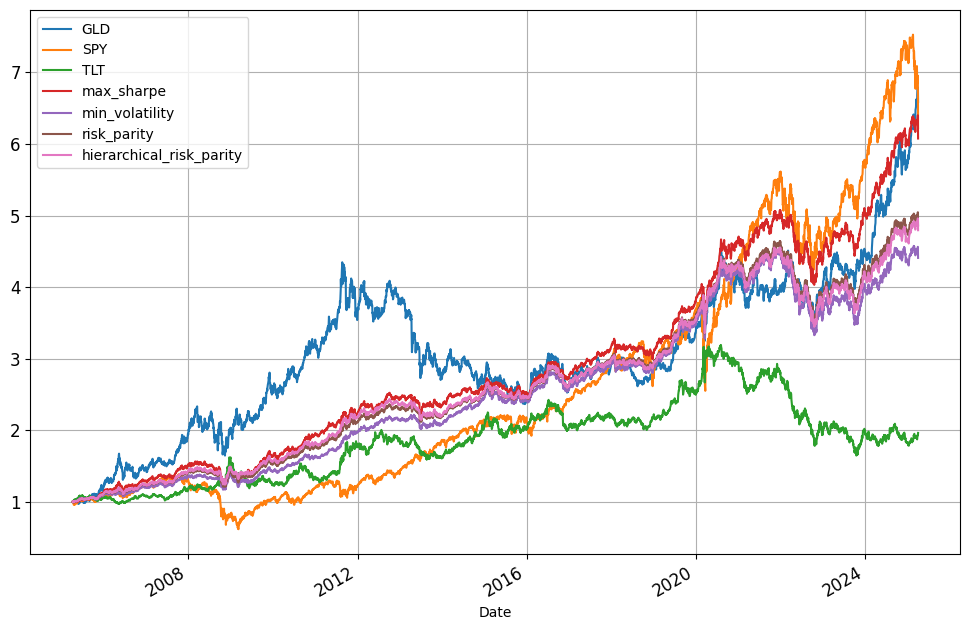

In [13]:
(
    1
    + pd.concat(
        [
            price_df.pct_change().dropna(),
            strategy(price_df, "max_sharpe"),
            strategy(price_df, "min_volatility"),
            strategy(price_df, "risk_parity"),
            strategy(price_df, "hierarchical_risk_parity"),
        ],
        axis=1,
    )
).cumprod().plot(figsize=(12, 8), grid=True, fontsize=12)